<a href="https://colab.research.google.com/github/nedokormysh/Stepik_Ai_edu_practical_ML/blob/week_11_ml_pipeline/PML_RegressionCompetition_oob_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Никнейм на каггл:** Berezutskiy_Ilya

Но вообще результаты уже только через late_submission. А потому в лидерборде нет. Сделал скрины: они в разделе blend и ensemble

# Imports

In [ ]:
!pip install catboost -q
# !pip install pytorch-tabnet -q
!pip install optuna -q
!pip install optuna-integration -q
!pip install dabl -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import plotly.express as px
import dabl

import optuna
from optuna.integration import CatBoostPruningCallback, LightGBMPruningCallback, XGBoostPruningCallback
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
from typing import Any

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, Dataset
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
# from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import NuSVR

from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline

from typing import Any, List, Tuple

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_regression

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import copy

import pickle
import warnings
warnings.simplefilter('ignore')

# Uploading data

In [ ]:
PATH_TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
PATH_TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [ ]:
TrainData = pd.read_csv(PATH_TRAIN)
TrainData.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [ ]:
TestData = pd.read_csv(PATH_TEST)
TestData.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,,
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica


# EDA

In [ ]:
train = TrainData.copy()
test = TestData.copy()

### NA

In [ ]:
train.isna().sum()

,0
Company,0
Specific Bean Origin,0
REF,0
Review,0
Cocoa Percent,0
Company Location,0
Rating,0
Bean Type,1
Broad Bean Origin,1


Есть пару пропусков в Bean Type, Broad Bean Origin

**Выводы:**
- У нас мало пропущенных значений. Можем их удалить.

In [ ]:
train.dropna(inplace=True)

In [ ]:
test.isna().sum()

,0
Company,0
Specific Bean Origin,0
REF,0
Review,0
Cocoa Percent,0
Company Location,0
Bean Type,0
Broad Bean Origin,0


Заменим названия столбцов

In [ ]:
train.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
test.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1253 non-null   object 
 1   Specific_Bean_Origin  1253 non-null   object 
 2   REF                   1253 non-null   int64  
 3   Review                1253 non-null   int64  
 4   Cocoa_Percent         1253 non-null   object 
 5   Company_Location      1253 non-null   object 
 6   Rating                1253 non-null   float64
 7   Bean_Type             1253 non-null   object 
 8   Broad_Bean_Origin     1253 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 97.9+ KB


### Pairplot

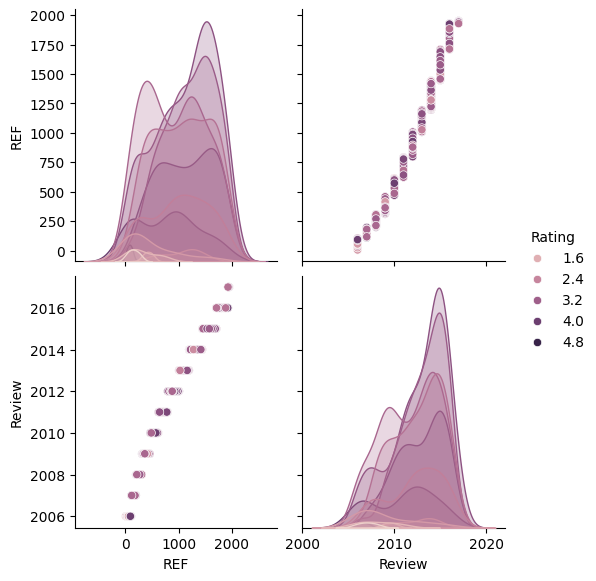

In [ ]:
g = sns.pairplot(train, kind='scatter', hue='Rating')
g.fig.set_size_inches(6,6)

**Выводы:**
- Видна линейная зависимость REF и review

In [ ]:
train.head()

,Company,Specific_Bean_Origin,REF,Review,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


### Company

In [ ]:
# sorted(train['Company'].unique().tolist())

В названиях компаний присутствуют само название и какая-то доп информация в скобках. Разобьём это на составляющие.

In [ ]:
train[['CompanyName', 'CompanySub']] = train['Company'].str.split('(', n=1, expand=True)
train['CompanySub'].fillna(value='Unknown', inplace = True)
train['CompanySub'] = train['CompanySub'].apply(lambda x: x.split(')')[0])
train = train.drop('Company', axis=1)

### Bean_Type

In [ ]:
train.head()

,Specific_Bean_Origin,REF,Review,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,CompanyName,CompanySub
0,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela,Willie's Cacao,Unknown
1,"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela,Beschle,Felchlin
2,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania,Dark Forest,Unknown
3,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic,Brasstown aka It's Chocolate,Unknown
4,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia,Pralus,Unknown


In [ ]:
train['Bean_Type'].unique()

array(['Trinitario', '\xa0', 'Criollo', 'Criollo, Trinitario',
       'Forastero (Arriba)', 'Amazon mix', 'Forastero (Arriba) ASS',
       'Forastero', 'Trinitario, Forastero', 'Forastero (Nacional)',
       'Criollo (Porcelana)', 'Criollo (Amarru)',
       'Forastero(Arriba, CCN)', 'Trinitario (Amelonado)', 'Blend',
       'Forastero (Parazinho)', 'Matina', 'Nacional (Arriba)',
       'Trinitario, TCGA', 'Criollo, Forastero', 'Criollo (Ocumare 77)',
       'Amazon, ICS', 'Nacional', 'Criollo (Ocumare)', 'Criollo, +',
       'Forastero (Catongo)', 'Amazon', 'Criollo (Wild)',
       'Trinitario, Criollo', 'EET', 'Trinitario (85% Criollo)',
       'Criollo (Ocumare 61)', 'Forastero, Trinitario',
       'Blend-Forastero,Criollo', 'Criollo (Ocumare 67)',
       'Forastero (Amelonado)', 'Trinitario, Nacional',
       'Forastero (Arriba) ASSS'], dtype=object)

Если изучить, то у нас тут есть смеси. Предположим, что через запямтую или микс или бленд - у нас смесь разных сортов какао. Добавим новый признак - смесь

In [ ]:
def is_blend(var):
    if pd.isna(var):
        return 0
    if ',' in var or 'mix' in var.lower() or 'blend' in var.lower():
        return 1
    return 0

# Добавление нового столбца 'IsBlend'
train['IsBlend'] = train['Bean_Type'].apply(is_blend)

In [ ]:
train.head()

,Specific_Bean_Origin,REF,Review,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,CompanyName,CompanySub,IsBlend
0,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela,Willie's Cacao,Unknown,0
1,"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela,Beschle,Felchlin,0
2,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania,Dark Forest,Unknown,0
3,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic,Brasstown aka It's Chocolate,Unknown,0
4,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia,Pralus,Unknown,0


In [ ]:
train['IsBlend'].value_counts()

,count
IsBlend,
0,1178
1,75


In [ ]:
train['Bean_Type'].unique()

array(['Trinitario', '\xa0', 'Criollo', 'Criollo, Trinitario',
       'Forastero (Arriba)', 'Amazon mix', 'Forastero (Arriba) ASS',
       'Forastero', 'Trinitario, Forastero', 'Forastero (Nacional)',
       'Criollo (Porcelana)', 'Criollo (Amarru)',
       'Forastero(Arriba, CCN)', 'Trinitario (Amelonado)', 'Blend',
       'Forastero (Parazinho)', 'Matina', 'Nacional (Arriba)',
       'Trinitario, TCGA', 'Criollo, Forastero', 'Criollo (Ocumare 77)',
       'Amazon, ICS', 'Nacional', 'Criollo (Ocumare)', 'Criollo, +',
       'Forastero (Catongo)', 'Amazon', 'Criollo (Wild)',
       'Trinitario, Criollo', 'EET', 'Trinitario (85% Criollo)',
       'Criollo (Ocumare 61)', 'Forastero, Trinitario',
       'Blend-Forastero,Criollo', 'Criollo (Ocumare 67)',
       'Forastero (Amelonado)', 'Trinitario, Nacional',
       'Forastero (Arriba) ASSS'], dtype=object)

Опять же есть в скобках какие-то уточнения. Попробуем также разбить и создать дополнительный столбец.

In [ ]:
train['Bean_Type'] = train['Bean_Type'].replace('Forastero (Arriba) ASSS', 'Forastero (Arriba)')
train['Bean_Type'] = train['Bean_Type'].replace('Forastero (Arriba) ASS', 'Forastero (Arriba)')

train[['Bean_Type', 'Bean_TypeSub']] = train['Bean_Type'].str.split('(', n=1, expand=True)
train['Bean_TypeSub'].fillna(value='Unknown', inplace = True)
train['Bean_TypeSub'] = train['Bean_TypeSub'].apply(lambda x: x.split(')')[0])

In [ ]:
train['Bean_Type'].unique()

array(['Trinitario', '\xa0', 'Criollo', 'Criollo, Trinitario',
       'Forastero ', 'Amazon mix', 'Forastero', 'Trinitario, Forastero',
       'Criollo ', 'Trinitario ', 'Blend', 'Matina', 'Nacional ',
       'Trinitario, TCGA', 'Criollo, Forastero', 'Amazon, ICS',
       'Nacional', 'Criollo, +', 'Amazon', 'Trinitario, Criollo', 'EET',
       'Forastero, Trinitario', 'Blend-Forastero,Criollo',
       'Trinitario, Nacional'], dtype=object)

In [ ]:
train['Bean_TypeSub'].unique()

array(['Unknown', 'Arriba', 'Nacional', 'Porcelana', 'Amarru',
       'Arriba, CCN', 'Amelonado', 'Parazinho', 'Ocumare 77', 'Ocumare',
       'Catongo', 'Wild', '85% Criollo', 'Ocumare 61', 'Ocumare 67'],
      dtype=object)

### Company_location

In [ ]:
train['Company_Location'].unique()

array(['U.K.', 'Switzerland', 'U.S.A.', 'France', 'Ecuador', 'Colombia',
       'Canada', 'Belgium', 'Spain', 'Italy', 'New Zealand', 'Venezuela',
       'Austria', 'Japan', 'Vietnam', 'Sweden', 'Madagascar', 'Brazil',
       'Peru', 'Honduras', 'Fiji', 'Australia', 'Eucador', 'Ireland',
       'Poland', 'Hungary', 'Germany', 'South Korea', 'Israel',
       'Guatemala', 'Domincan Republic', 'Denmark', 'Grenada',
       'Lithuania', 'Scotland', 'Argentina', 'Finland', 'Singapore',
       'South Africa', 'Ghana', 'Chile', 'Puerto Rico', 'India',
       'Costa Rica', 'Sao Tome', 'St. Lucia', 'Nicaragua', 'Mexico',
       'Bolivia', 'Niacragua', 'Iceland', 'Amsterdam', 'Wales',
       'Netherlands', 'Russia', 'Portugal', 'Suriname', 'Czech Republic'],
      dtype=object)

Здесь исправим только название Доминиканской республики

In [ ]:
train['Company_Location'] = train['Company_Location'].replace('Domincan Republic', 'Dominican Republic')

### Broad_Bean_Origin

In [ ]:
# sorted(train['Broad_Bean_Origin'].unique().tolist())

В названиях присутствую повторы и дублирования.

In [ ]:
train.head()

,Specific_Bean_Origin,REF,Review,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,CompanyName,CompanySub,IsBlend,Bean_TypeSub
0,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela,Willie's Cacao,Unknown,0,Unknown
1,"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela,Beschle,Felchlin,0,Unknown
2,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania,Dark Forest,Unknown,0,Unknown
3,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic,Brasstown aka It's Chocolate,Unknown,0,Unknown
4,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia,Pralus,Unknown,0,Unknown


In [ ]:
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace('Domincan Republic', 'Dominican Republic')
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace('Trinidad-Tobago', 'Trinidad, Tobago')
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace("Peru, Mad., Dom. Rep.", "Peru, Madagascar, Dominican Republic")
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace("Central and S. America", "Central and South America")
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace("PNG, Vanuatu, Mad", "Papua New Guinea, Vanuatu, Madagascar")
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace("Ven., Trinidad, Mad.", "Venezuela, Trinidad, Madagascar")
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace("Ven.,Ecu.,Peru,Nic.", "Venezuela, Ecuador, Peru, Nicaragua")
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace("Ven, Trinidad, Ecuador","Venezuela, Trinidad, Ecuador")
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace("Ghana, Domin. Rep", "Ghana, Dominican Republic")
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace("Ecuador, Mad., PNG","Ecuador, Madagascar, Papua New Guinea")
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace("Mad., Java, PNG","Madagascar, Java, Papua New Guinea")
train['Broad_Bean_Origin'] = train['Broad_Bean_Origin'].replace("Gre., PNG, Haw., Haiti, Mad", "Grenada, Papua New Guinea, Hawaii, Haiti, Madagascar")

### Cocoa_Percent

In [ ]:
# def prep_data(data):
#     # Удаление знака процента из колонки 'Cocoa percent'
#     data['Cocoa_Percent'] = data['Cocoa_Percent'].str.replace('%', '')
#     data['Cocoa_Percent'] = pd.to_numeric(data['Cocoa_Percent'])

#     # data['Review'] = pd.to_numeric(data['Review'])
#     # data['REF'] = pd.to_numeric(data['REF'])
#     # Удаление пропущенных значений
#     data.dropna(inplace=True)

#     # Замена на NaN
#     data = data.replace('\xa0', np.nan)

#     return data

In [ ]:
# train = prep_data(train)
# test = prep_data(test)

Удалим знак процента.

In [ ]:
train['Cocoa_Percent'] = train['Cocoa_Percent'].str.replace('%', '')
train['Cocoa_Percent'] = pd.to_numeric(train['Cocoa_Percent'])

### Описательная статистика числовых признаков

In [ ]:
# summary statistics
train.describe()#.style.background_gradient(cmap = "plasma")

,REF,Review,Cocoa_Percent,Rating,IsBlend
count,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000
mean,1045.483639,2012.383879,71.791700,3.176377,0.059856
std,551.624106,2.924551,6.402353,0.478383,0.237315
min,5.000000,2006.000000,46.000000,1.000000,0.000000
25%,593.000000,2010.000000,70.000000,2.750000,0.000000
50%,1081.000000,2013.000000,70.000000,3.250000,0.000000
75%,1514.000000,2015.000000,75.000000,3.500000,0.000000
max,1952.000000,2017.000000,100.000000,5.000000,1.000000


**Выводы:**
- Есть вопросы к 100 процентам в cocoa_percent, но пока не могу сказать насколько это неверные значения.

### REF Review

<Axes: >

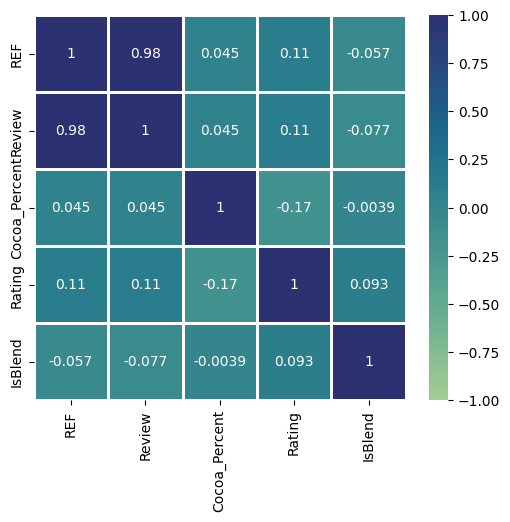

In [ ]:
#корреляция числовых признаков
fig = plt.figure(figsize = (6,5))
sns.heatmap(train.corr(numeric_only = True),
            cmap = "crest",
            annot = True,
            linewidths=1, linecolor='w',
            vmax = 1, vmin = -1)

REF и Review коллинеарны

In [ ]:
train = train.drop(['REF'], axis = 1)
# test = test.drop(['REF'], axis = 1)

In [ ]:
# # Обработка пропущенных значений (выберите один из методов)
# # Метод 1: Удаление строк с пропущенными значениями
# # TrainData = TrainData.dropna(subset=['Bean_Type'])

# # Метод 2: Заполнение пропущенных значений наиболее часто встречающимся значением
# # most_frequent_bean_type = TrainData['Bean_Type'].mode()[0]
# # TrainData['Bean_Type'].fillna(most_frequent_bean_type, inplace=True)

# # Метод 3: Заполнение пропущенных значений специальным значением, например, 'Unknown'
# train.fillna('Unknown', inplace=True)

### '\xa0'


У нас присутсвовал везде '\xa0'

Изначально менял все на Unknown, но затем решил менять всё на '' (предлагалось на занятии). В классе препроцессинг (ниже) использовал ''.

In [ ]:
train = train.replace('\xa0', 'Unknown')

In [ ]:
train.head()

,Specific_Bean_Origin,Review,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,CompanyName,CompanySub,IsBlend,Bean_TypeSub
0,Rio Caribe,2009,72.0,U.K.,3.25,Trinitario,Venezuela,Willie's Cacao,Unknown,0,Unknown
1,"Ocumare, Premier Cru, Quizas No. 2",2010,72.0,Switzerland,3.50,Unknown,Venezuela,Beschle,Felchlin,0,Unknown
2,Tanzania,2015,70.0,U.S.A.,3.00,Unknown,Tanzania,Dark Forest,Unknown,0,Unknown
3,Cooproagro,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic,Brasstown aka It's Chocolate,Unknown,0,Unknown
4,"Java, Indonesie",2006,75.0,France,3.50,Criollo,Indonesia,Pralus,Unknown,0,Unknown


### Описательная статистика категориальных признаков

In [ ]:
#посмотрим статистику категориальных признаков
train.describe(include='object')

,Specific_Bean_Origin,Company_Location,Bean_Type,Broad_Bean_Origin,CompanyName,CompanySub,Bean_TypeSub
count,1253,1253,1253,1253,1253,1253,1253
unique,761,58,24,82,373,39,15
top,Madagascar,U.S.A.,Unknown,Venezuela,Soma,Unknown,Unknown
freq,38,520,628,144,34,1106,1147


## Анализ

Сложно назвать полноценным анализом. Мне было сложно придумать гипотезы какие признаки влияют на целевую переменную, поэтому просто хотел взглянуть на какие-нибудь графики.

### Cocoa_Percent - Rating

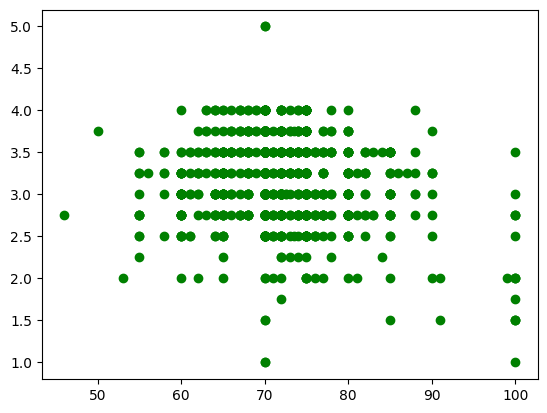

In [ ]:
plt.scatter(train.loc[:,'Cocoa_Percent'].tolist(), train.loc[:,'Rating'].tolist(), c='green')
plt.show()

### Dabl

Target looks like regression


[<Axes: title={'center': 'Target distribution'}, xlabel='Rating', ylabel='frequency'>,
 array([[<Axes: title={'center': 'F=-1.21E-01'}, xlabel='Cocoa_Percent', ylabel='Rating'>,
         <Axes: title={'center': 'F=8.55E-02'}, xlabel='Review (jittered)'>]],
       dtype=object),
 array([[<Axes: title={'center': 'F=3.84E-02'}, xlabel='Rating', ylabel='Bean_Type'>,
         <Axes: title={'center': 'F=3.18E-02'}, xlabel='Rating', ylabel='CompanySub'>,
         <Axes: title={'center': 'F=1.12E-02'}, xlabel='Rating', ylabel='IsBlend'>,
         <Axes: title={'center': 'F=9.06E-03'}, xlabel='Rating', ylabel='Bean_TypeSub'>]],
       dtype=object)]

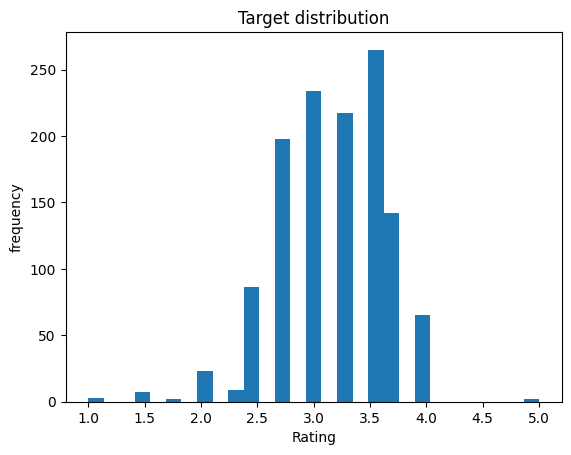

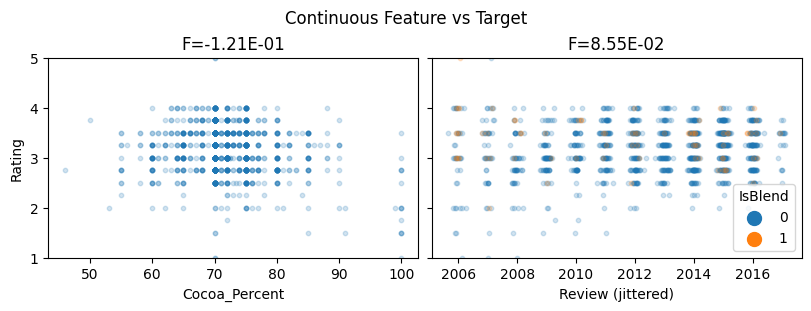

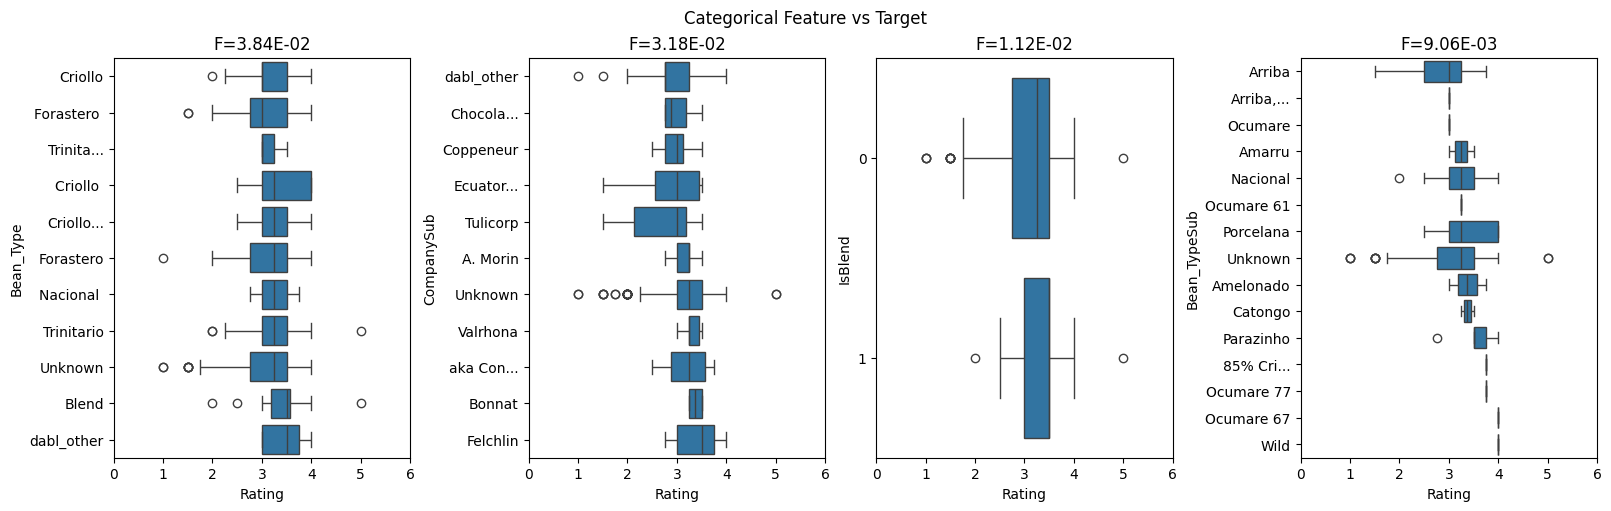

In [ ]:
dabl.plot(train, target_col="Rating")

**Выводы:**
- не вижу особых явных зависимостей в непрерывных признаках. Всё таки странными выглядт 100 процентов какао.
- в категориальных да есть какие-то выбросы, но в целом средниие сильно отличаются тольков Bean_TypeSub
- целевая переменная выглядит достаточно близко к нормальной. хотя это можно было бы и проверить.

### Страна происхождения с самым высоким рейтингом

In [ ]:
highest_rating_by_origin = train.groupby('Broad_Bean_Origin')['Rating'].max().reset_index()

# Create a bar plot to visualize the highest ratings by bean origin
fig1 = px.bar(highest_rating_by_origin, x='Broad_Bean_Origin', y='Rating',
              title='Highest Rating by Bean Origin',
              labels={'Broad_Bean_Origin': 'Bean Origin', 'Rating': 'Highest Rating'})

# Display the plot
fig1.show()

**Выводы:**
- Из стран Венесуэла выделяется по рейтингу. Также по рейтингу выделяется блок без данных, т.е. Unknown

In [ ]:
# train[train['Broad_Bean_Origin'] == 'Unknown'].count()
train['Broad_Bean_Origin'].value_counts().get('Unknown', 0)

55

В принципе у нас относительно много строк с неопределённой страной.

### Процент шоколада, рейтинг

In [ ]:
fig2 = px.scatter(train, x='Cocoa_Percent', y='Rating',# color='Company',
                  title='Cocoa Percent vs Rating',
                  labels={'Cocoa_Percent': 'Cocoa Percent', 'Rating': 'Rating'},
                  trendline='ols')

fig2.show()

**Выводы:**
- не вижу зависимости, разве что с процентом 100 рейтинг чуть ниже, но и таких значений меньше. Сложно сказать есть такая зависимость. И вообще 100 процентов - это не выброс ли. Надо бы изучить предметную область.

### Страна фирмы производителя

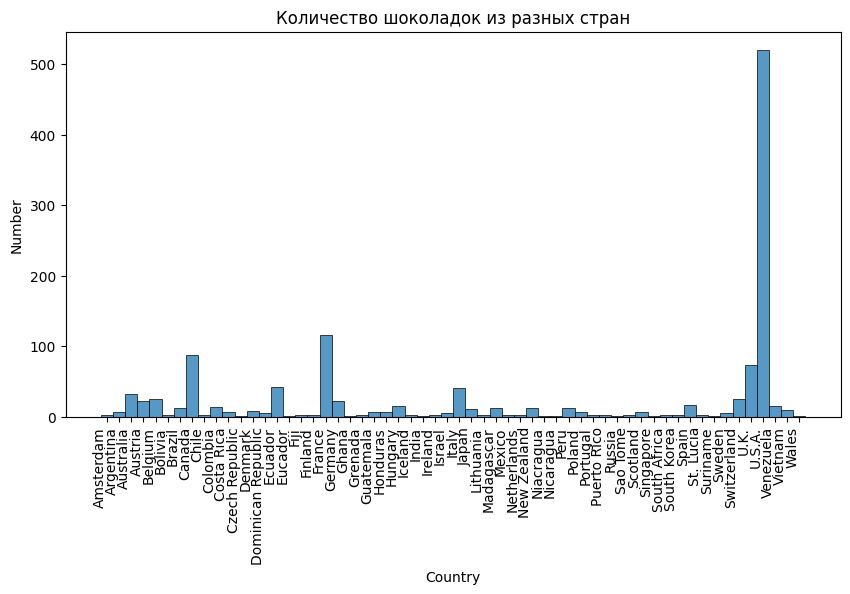

In [ ]:
train['Company_Location'] = pd.Categorical(train['Company_Location'])


plt.figure(figsize=(10, 5))
sns.histplot(data=train,
             x='Company_Location',
             stat='count',
            #  hue='Rating',
             fill='#8B4513',
            #  kde=True,
             linewidth=0.5,
             edgecolor='black')


plt.xticks(rotation=90, ha='right')
plt.title('Количество шоколадок из разных стран')
plt.xlabel('Country')
plt.ylabel('Number')

plt.show()

**Выводы:**
- Больше всего фирм зарегистрировано в Венесуэле

# Data prep

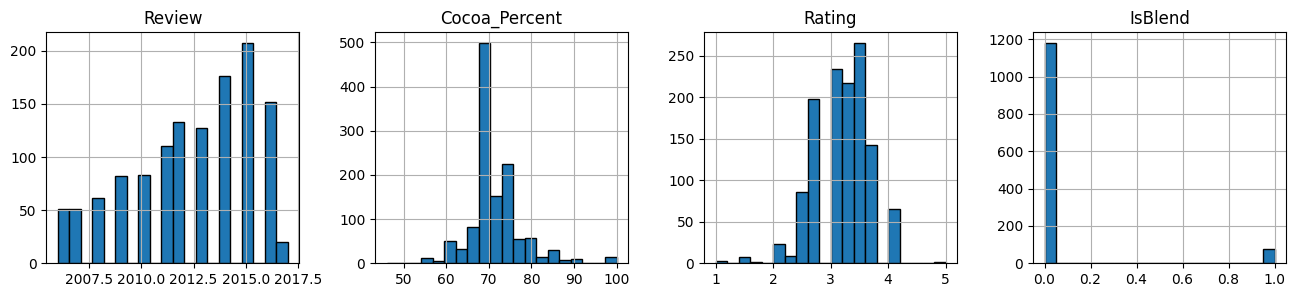

In [ ]:
train.hist(figsize=(16,3), layout=(-1,4), bins=20, edgecolor='black');

In [ ]:
train.duplicated().any().any()

False

<Axes: >

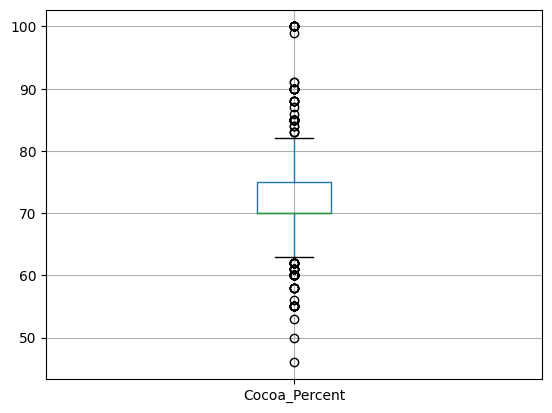

In [ ]:
train[['Cocoa_Percent']].boxplot()

В Review нет выбросов. А в cocoa_percent есть, но логики обрабатывать эти выбросы пока не вижу. Есть вопросы к 100 процентам.

In [ ]:
train[train['Cocoa_Percent'] == 100].count()

,0
Specific_Bean_Origin,14
Review,14
Cocoa_Percent,14
Company_Location,14
Rating,14
Bean_Type,14
Broad_Bean_Origin,14
CompanyName,14
CompanySub,14
IsBlend,14


In [ ]:
train.shape

(1253, 11)

## New features

Попробуем обработать выбросы через добавление нового категориального признака.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Specific_Bean_Origin    1253 non-null   object  
 1   Review                  1253 non-null   int64   
 2   Cocoa_Percent           1253 non-null   float64 
 3   Company_Location        1253 non-null   category
 4   Rating                  1253 non-null   float64 
 5   Bean_Type               1253 non-null   object  
 6   Broad_Bean_Origin       1253 non-null   object  
 7   CompanyName             1253 non-null   object  
 8   CompanySub              1253 non-null   object  
 9   IsBlend                 1253 non-null   int64   
 10  Bean_TypeSub            1253 non-null   object  
 11  Cocoa_Percent_Category  1253 non-null   object  
dtypes: category(1), float64(2), int64(2), object(7)
memory usage: 153.5+ KB


In [ ]:
# Процентное содержание какао
def categorize_cocoa_percent(percent):
    # print(percent)
    if percent < 60:
        return 'Low'
    elif 60 <= percent < 80:
        return 'Medium'
    else:
        return 'High'

train['Cocoa_Percent_Category'] = train['Cocoa_Percent'].apply(categorize_cocoa_percent)
# test['Cocoa_Percent_Category'] = test['Cocoa_Percent'].apply(categorize_cocoa_percent)

Добавим признак является ли страна производитель и страна происхождения бобов

In [ ]:
# Проверка на производителя
def domestic(data):
    data['Is_Domestic'] = np.where(data['Company_Location'] == data['Broad_Bean_Origin'], 1, 0)
    return data

train = domestic(train)
# test = domestic(test)

In [ ]:
train.shape#, test.shape

(1253, 13)

In [ ]:
# TrainData['Company_Length'] = TrainData['Company'].apply(len)

## Инициализация

## Класс препроцессинга

соберём все изменения вместе

In [ ]:
class DataPreprocessing():
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.modes = None

    def fit(self, data):
        """Сохранение статистик"""
        # Расчет медиан
        # self.medians = data.median()
        self.modes = data.mode().iloc[0]

    @staticmethod
    def categorize_cocoa_percent(percent):
        if percent < 60:
            return 'Low'
        elif 60 <= percent < 80:
            return 'Medium'
        else:
            return 'High'

    @staticmethod
    def is_blend(var):
        if pd.isna(var):
            return 0
        if ',' in var or 'mix' in var.lower() or 'blend' in var.lower():
            return 1
        return 0

    def fill_nan_with_mode(self, df):
        for column in df.columns:
            mode_value = self.modes[column]
            df[column].fillna(mode_value, inplace=True)
        return df

    def transform(self, data):
        """Трансформация данных"""

        # NA
        data.dropna(inplace=True)

        # _

        data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

        # Company

        data[['CompanyName', 'CompanySub']] = data['Company'].str.split('(', n=1, expand=True)
        data['CompanySub'].fillna(value='', inplace = True)
        data['CompanySub'] = data['CompanySub'].apply(lambda x: x.split(')')[0])
        data = data.drop('Company', axis=1)

        # Bean_Type

        # Добавление нового столбца 'IsBlend'
        data['IsBlend'] = data['Bean_Type'].apply(DataPreprocessing.is_blend)

        data['Bean_Type'] = data['Bean_Type'].replace('Forastero (Arriba) ASSS', 'Forastero (Arriba)')
        data['Bean_Type'] = data['Bean_Type'].replace('Forastero (Arriba) ASS', 'Forastero (Arriba)')

        data[['Bean_Type', 'Bean_TypeSub']] = data['Bean_Type'].str.split('(', n=1, expand=True)
        data['Bean_TypeSub'].fillna(value='', inplace = True)
        data['Bean_TypeSub'] = data['Bean_TypeSub'].apply(lambda x: x.split(')')[0])

        # Company_Location

        data['Company_Location'] = data['Company_Location'].replace('Domincan Republic',
                                                                      'Dominican Republic')

        # Broad_Bean_Origin

        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace('Domincan Republic', 'Dominican Republic')
        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace('Trinidad-Tobago', 'Trinidad, Tobago')
        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace("Peru, Mad., Dom. Rep.", "Peru, Madagascar, Dominican Republic")
        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace("Central and S. America", "Central and South America")
        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace("PNG, Vanuatu, Mad", "Papua New Guinea, Vanuatu, Madagascar")
        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace("Ven., Trinidad, Mad.", "Venezuela, Trinidad, Madagascar")
        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace("Ven.,Ecu.,Peru,Nic.", "Venezuela, Ecuador, Peru, Nicaragua")
        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace("Ven, Trinidad, Ecuador","Venezuela, Trinidad, Ecuador")
        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace("Ghana, Domin. Rep", "Ghana, Dominican Republic")
        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace("Ecuador, Mad., PNG","Ecuador, Madagascar, Papua New Guinea")
        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace("Mad., Java, PNG","Madagascar, Java, Papua New Guinea")
        data['Broad_Bean_Origin'] = data['Broad_Bean_Origin'].replace("Gre., PNG, Haw., Haiti, Mad", "Grenada, Papua New Guinea, Hawaii, Haiti, Madagascar")


        # Cocoa_Percent

        data['Cocoa_Percent'] = data['Cocoa_Percent'].str.replace('%', '')
        data['Cocoa_Percent'] = pd.to_numeric(data['Cocoa_Percent'])


        # REF

        data = data.drop(['REF'], axis = 1)

        # \xa0

        data = data.replace('\xa0', '')
        # data = data.replace('Unknown', np.nan)

        # Cocoa_Percent_Category

        data['Cocoa_Percent_Category'] = data['Cocoa_Percent'].apply(DataPreprocessing.categorize_cocoa_percent)


        # IsDomestic

        data['Is_Domestic'] = np.where(data['Company_Location'] == data['Broad_Bean_Origin'], 1, 0)

        # # Заполнение пропусков модами
        # data = self.fill_nan_with_mode(data)

        return data

In [ ]:
train = TrainData.copy()
test = TestData.copy()

preprocessor = DataPreprocessing()
preprocessor.fit(train)

train = preprocessor.transform(train)
test = preprocessor.transform(test)

train.shape, test.shape

((1253, 13), (540, 12))

In [ ]:
# g = sns.pairplot(train, kind='scatter', hue='Rating')
# g.fig.set_size_inches(6,6)

In [ ]:
# test['Broad_Bean_Origin'].unique()

In [ ]:
train.head()

,Company,Specific_Bean_Origin,Review,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,Cocoa_Percent_Category,Is_Domestic
0,Willie's Cacao,Rio Caribe,2009,72.0,U.K.,3.25,Trinitario,Venezuela,Medium,0
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",2010,72.0,Switzerland,3.50,Unknown,Venezuela,Medium,0
2,Dark Forest,Tanzania,2015,70.0,U.S.A.,3.00,Unknown,Tanzania,Medium,0
3,Brasstown aka It's Chocolate,Cooproagro,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic,Medium,0
4,Pralus,"Java, Indonesie",2006,75.0,France,3.50,Criollo,Indonesia,Medium,0


In [ ]:
test.head()

,Specific_Bean_Origin,Review,Cocoa_Percent,Company_Location,Bean_Type,Broad_Bean_Origin,CompanyName,CompanySub,IsBlend,Bean_TypeSub,Cocoa_Percent_Category,Is_Domestic
0,"San Juan Estate, Gran Couva",2015,70.0,U.S.A.,Trinitario,Trinidad,Ohiyo,Unknown,0,Unknown,Medium,0
1,Organic Dark,2009,72.0,Spain,Unknown,Unknown,Blanxart,Unknown,0,Unknown,Medium,0
2,Maya Mountain,2015,80.0,U.S.A.,Trinitario,Belize,Brazen,Unknown,0,Unknown,High,0
3,Madagascar,2009,67.0,U.S.A.,Trinitario,Madagascar,Patric,Unknown,0,Unknown,Medium,0
4,"Upala, Batch 12",2010,82.0,U.S.A.,Matina,Costa Rica,Potomac,Unknown,0,Unknown,High,0


In [ ]:
# инициализируем листы числовых, категориальных, целевых признаков и признаки, которые не потребуются для анализа.
cat_features = ['Specific_Bean_Origin',
                'Company_Location',
                'Bean_Type',
                'Broad_Bean_Origin',
                'CompanyName',
                'CompanySub',
                'IsBlend',
                'Bean_TypeSub',
                'Cocoa_Percent_Category',
                'Is_Domestic'
                ]

targets = ['Rating']
features2drop = ['REF']

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print(f'\033[1mcat_features:\033[0m {cat_features}, \033[1mamount\033[0m = {len(cat_features)}')
print(f'\033[1mnum_features:\033[0m {num_features}, \033[1mamount\033[0m = {len(num_features)}')
print(f'\033[1mtargets:\033[0m {targets}, \033[1mamount\033[0m = {len(targets)}')

cat_features: ['Specific_Bean_Origin', 'Company_Location', 'Bean_Type', 'Broad_Bean_Origin', 'CompanyName', 'CompanySub', 'IsBlend', 'Bean_TypeSub', 'Cocoa_Percent_Category', 'Is_Domestic'], amount = 10
num_features: ['Review', 'Cocoa_Percent'], amount = 2
targets: ['Rating'], amount = 1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Specific_Bean_Origin    1253 non-null   object 
 1   Review                  1253 non-null   int64  
 2   Cocoa_Percent           1253 non-null   float64
 3   Company_Location        1253 non-null   object 
 4   Rating                  1253 non-null   float64
 5   Bean_Type               1253 non-null   object 
 6   Broad_Bean_Origin       1253 non-null   object 
 7   CompanyName             1253 non-null   object 
 8   CompanySub              1253 non-null   object 
 9   IsBlend                 1253 non-null   int64  
 10  Bean_TypeSub            1253 non-null   object 
 11  Cocoa_Percent_Category  1253 non-null   object 
 12  Is_Domestic             1253 non-null   int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 137.0+ KB


In [ ]:
# Заменим тип данных object на category в категориальных признаках

for col in cat_features:
    train[col] = train[col].astype("category")

for col in cat_features:
    test[col] = test[col].astype("category")

In [ ]:
# инициализируем номер случайного состояния, словарь лучших моделей, словарь для результатов
# датасет для формирования результатов
R_S = 7575
N_EST = 400
N_TRIALS = 200
sampler = optuna.samplers.TPESampler(seed=R_S)
TOP_F = 12
bst_mdls = {}
mean_scores = {}

df_sub = test.copy()

# Split

In [ ]:
# получаем разбиение на фичи и целевую переменную
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["Rating"]

Будем производить кросс-валидацию, не будем разбивать данные на тестовые и валидационные здесь. Помимо этого на каждом фолде будем получать прогноз для тестового датасета. В конце применения модели усредним прогноз со всех фолдов.

In [ ]:
# разбиение на обучающую и валидационную выборки
# X_train, X_val, y_train, y_val = train_test_split(X,
#                                                   y,
#                                                   test_size=0.15,
#                                                   random_state=R_S,
#                                                   )

In [ ]:
# подготовка тестовых данных
X_sub = test[filtered_features].drop(targets, axis=1, errors="ignore")

In [ ]:
print(f"X_shape: {X.shape}")
# print(f"X_train shape: {X_train.shape}")
# print(f"X_val shape: {X_val.shape}")
# print(f"X_sub shape: {X_sub.shape}")

X_shape: (1253, 12)


# Additional functions

## Класс для нормализации числовых признаков

Класс для нормализации числовых признаков. Хочу в catboost категориальные признаки подать как список, чтобы catboost сам работал над такими признаками. Но мне надо нормализовать числовые признаки. Для этого пришлось сделать класс, который обрабатывает числовые признаки, а категориальные не трогает и возвращает цельный датафрейм.

In [ ]:
class CustomTransformer(TransformerMixin):
    '''
    .. notes::
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки не изменяются.
    После трансформаци возвращается датафрейм.
    '''
    def __init__(self,
                 scaler_type: Any=None,
                 cat_feats: list[str]=None,
                 with_mean: bool=True,
                 with_std: bool=True,
                 feature_range: tuple[int, int]=(0, 1)):

        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.cat_feats = cat_feats

        # print('Init done')
    def fit(self, X: pd.DataFrame, y: pd.Series=None):
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series=None) -> pd.DataFrame:

        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        num_feats = [i for i in X_.columns if i not in self.cat_feats]

        X_num_trans = X_[num_feats]
        X_num_trans = pd.DataFrame(self.scaler.fit_transform(X_num_trans), columns=num_feats)

        res = pd.concat([X_cat.reset_index(), X_num_trans], axis=1)

        return res.set_index('index')

## Функция для шага обучения

Хотел использовать везде замедление шага обучения. Но в конечном итоге результаты были неоднозначно лучше. И использовал только в LGBM.

In [ ]:
# функция для шага обучения
def lr_gen_simple(init_lr: float=0.1, epoch: int=400) -> list[float]:
    '''
    :param init_lr: initial number for learning rate
    :type init_lr: float, defaults to 0.1
    :param epoch: amount of epochs
    :type epoch: int, defaults to 400

    :rtype: list[float]

    .. notes:: Функция для формирования листа со значениями шага обучения
    на каждой эпохе.
    -----
    Параметры:
    init_lr - инициализирующий шаг обучения
    epoch - количество эпох

    '''
    decay = init_lr / epoch
    lr_list = [init_lr/(1 + decay * i) for i in range(1, epoch + 1)]

    return lr_list

## Класс для применения моделей

Класс для применения моделей. Т.к. хотел некий конструктор для разных моделей, то был создан класс. Мы сначала в кросс-валидации разбиваем данные, и подаем их в данный класс, где уже идёт пайплайн нормализации числовых признаков, кодирования категориальных, и обучение модели.

In [ ]:
class FitClass:
    '''
    Класс для применения моделей.
    preparing_features - функция для создания пайплайнов обработки
    fit - применение модели
    '''
    @staticmethod
    def preparing_features(name: str, algorithm: Any,
                           num_top:int =TOP_F
                           ) -> Tuple[Any, Any]:


        '''
        :param name: name of regressor algorithm
        :type name: str
        :param algorithm: class of regressor algorithm
        :type algorithm: Any

        :rtype: Tuple[Any, Any]
        :returns: preprocessor pipe for columns and pipe model

        .. notes::
        -----
        Принимает на вход название алгоритма и алгоритм.
        Возвращает цепочку для преобразования фичей,
        цепочку для преобразования фичей и применения модели.
        '''

        if name == 'CatBoostRegressor':
            preprocessor = CustomTransformer(True, cat_feats=cat_features)
            pipe = Pipeline([
                ('feature_preprocessor', preprocessor),
                ('model', algorithm)
            ])
        else:
            numeric_transformer = Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler())
                ]
            )
            categorical_transformer = Pipeline(
                steps=[
                    ("encoder", OneHotEncoder(handle_unknown="ignore"))
                ]
            )
            preprocessor = ColumnTransformer(
                transformers=[
                    ("num", numeric_transformer, num_features),
                    ("cat", categorical_transformer, cat_features)
                ]
            )

            pipe = Pipeline([
                ('feature_preprocessor', preprocessor),
                # ('feature_selection', SelectKBest(score_func=f_regression, k=num_top)),
                ('model', algorithm)
            ])
        return preprocessor, pipe

    @staticmethod
    def fit(name: str,
            pipe: Any,
            preprocessor: Any,
            X_train: pd.DataFrame,
            X_val: pd.DataFrame,
            y_train: pd.Series,
            y_val: pd.Series,
            fit_params: dict,
            callbacks=[]):
        '''
        :param name: name of regressor algorithm
        :type name: str
        :param pipe: pipe of preprocessor for features and model
        :type pipe: Any
        :param preprocessor: pipe of preprocessor for features
        :type preprocessor: Any
        :param X_train: train features
        :type X_train: pandas.DataFrame
        :param X_val: validation features
        :type X_val: pandas.DataFrame
        :param y_train: train target
        :type y_train: pandas.Series
        :param y_val: validation target
        :type y_val: pandas.Series

        :rtype: Tuple[np.array, Any]
        :returns: array of predictions, model
        .. notes::
        -----
        Принимает название алгоритма. Применяет алгоритм с заданными параметрами
        к данным.
        Возвращает предсказание. И обученную модель.
        '''


        if name == 'TabNetRegressor':
            target_sc = StandardScaler()
            y_train = target_sc.fit_transform(y_train.values.reshape(-1, 1))
            X_val_eval_NN = X_val.copy()
            eval_set_pipe = Pipeline(steps=[('feature_preprocessor', preprocessor)])
            X_val_eval_NN = eval_set_pipe.fit(X_train).transform(X_val_eval_NN)
            y_val_eval_NN = target_sc.transform(y_val.values.reshape(-1, 1))
        else:
            X_val_eval = X_val.copy()
            eval_set_pipe = Pipeline(steps=[('feature_preprocessor', preprocessor)])
            X_val_eval = eval_set_pipe.fit(X_train).transform(X_val_eval)

        # wrapped_model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
        wrapped_model = pipe

        if name in ['KNeighborsRegressor',
                    'ElasticNet',
                    'RandomForestRegressor',
                    'GaussianProcessRegressor',
                    'NuSVR',
                    'MLPRegressor',
                    'GradientBoostingRegressor',
                    'LinearRegression']:
            wrapped_model.fit(X_train,
                              y_train,
                              **fit_params)
            y_pred = wrapped_model.predict(X_val)
        elif name == 'TabNetRegressor':
            pipe.fit(X_train, y_train,
                    model__eval_set=[(X_val_eval_NN, y_val_eval_NN)],
                    **fit_params)
            y_pred = pipe.predict(X_val)
            y_pred = target_sc.inverse_transform(np.array(y_pred).reshape(-1, 1))
            wrapped_model = pipe

        else:
            if callbacks:
                # print(X_val_eval.shape, y_val.shape)
                wrapped_model.fit(X_train,
                                  y_train,
                                  **fit_params,
                                  model__callbacks=callbacks,
                                  model__eval_set=[(X_val_eval, y_val)])
                # запускаем процесс прунинга для catboost
                if name == 'CatBoostRegressor':
                    callbacks[-1].check_pruned()
            else:
                wrapped_model.fit(X_train,
                                  y_train,
                                  model__eval_set=[(X_val_eval, y_val)],
                                  **fit_params)

            y_pred = wrapped_model.predict(X_val)

        if name == 'TabNetRegressor':
            return y_pred, wrapped_model, target_sc

        return y_pred, wrapped_model

## Fit algorithm optuna

In [ ]:
# функция применения алгоритма, когда применяем optuna
def fit_algorithm_optuna(trial: optuna.trial,
                         train: pd.DataFrame,
                         val: pd.DataFrame,
                         algorithm: Any,
                         init_params: dict,
                         grid: dict,
                         fit_params: dict,
                         r_s=R_S,
                         callbacks = []):
    '''
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param train: train dataframe
    :type train: pandas.DataFrame
    :param val: validation dataframe
    :type val: pandas.DataFrame
    :param algorithm: class of regressor algorithm
    :type algorithm: Any
    :param init_params: initial parameters
    :type init_params: dict
    :param grid: grid of parameters
    :type grid: dict
    :param fit_params: parameters to fit
    :type fit_params: dict
    :param r_s: random state
    :type r_s: int, defaults to 7575
    :param callbacks: callbacks
    :type callbacks: list, defaults to []

    :rtype: tuple[Any, np.array]
    :returns: model, array of predictions
    .. notes::
    -----
    Принимает объект trial из optuna, данные для обучения и валидации, алгоритм, параметры.
    Алгоритм обучается и применяется.
    Возвращает обученную модель и предсказанное значение для валидационной выборки.
    '''

    X_train, y_train = train
    X_val, y_val = val

    # получаем на вход сетку с параметрами для перебора. для пары алгоритмов будем
    # добавлять параметры в сетку, в зависимости от некоторых условий.
    if algorithm.__name__ == 'CatBoostRegressor':
        if grid["bootstrap_type"] == "Bayesian":
            grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif grid["bootstrap_type"] == "Bernoulli":
            grid["subsample"] = trial.suggest_float("subsample", 0.1, 1, step=0.01)
    elif algorithm.__name__ == 'XGBRegressor':
        if grid["booster"] == "gbtree" or grid["booster"] == "dart":
            grid["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            grid["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            grid["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            grid["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
            grid["tree_method"]: trial.suggest_categorical("tree_method", ['hist', 'approx'],)
        if grid["booster"] == "dart":
            grid["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            grid["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            grid["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
            grid["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    elif algorithm.__name__ == 'LGBMRegressor':
        if init_params['boosting_type'] != 'goss':
            grid['bagging_fraction'] = trial.suggest_float('bagging_fraction', 0.5, 1.0, step=0.01)
            grid['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 20)
        if init_params['boosting_type'] == 'dart':
            grid['drop_rate'] = trial.suggest_float('drop_rate', 0.1, 0.6, step=0.01)

    # в теории можно было бы для каждой модели выбрать количество признаков, но
    # оставил все признаки, т.к. их было мало
    num_top = X.shape[1]


    # if algorithm.__name__ == 'KNeighborsRegressor':
    #     num_top = trial.suggest_int("num_top", 1, X.shape[1], step=1)
    # elif algorithm.__name__ == 'ElasticNet':
    #     num_top = trial.suggest_int("num_top", 1, X.shape[1], step=1)
    # elif algorithm.__name__ == 'GradientBoostingRegressor':
    #     num_top = trial.suggest_int("num_top", 1, X.shape[1], step=20)
    # elif algorithm.__name__ == 'RandomForestRegressor':
    #     num_top = trial.suggest_int("num_top", 1, 1000, step=20)
    # elif algorithm.__name__ == 'NuSVR':
    #     num_top = trial.suggest_int("num_top", 1, X.shape[1], step=20)


    rgr = algorithm(**init_params, **grid)

    # применяем метод preparing_features - он на вернёт способ обработки данных и общий пайплайн модели
    preprocessor, pipe = FitClass.preparing_features(algorithm.__name__,
                                                     rgr,
                                                     num_top
                                                     )

    # для алгоритма TabNet будем возвращать ещё и обученный объект scaler для целевой переменной
    if algorithm.__name__ == 'TabNetRegressor':
        y_pred, wrapped_model, target_sc = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)
        return wrapped_model, y_pred, target_sc

    y_pred, wrapped_model = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)

    # возвращаем модель и прогноз
    return wrapped_model, y_pred


# Models

In [ ]:
df_sub = pd.DataFrame()
df_sub['id'] = np.arange(len(test))

## KNN

In [ ]:
def objective_knn(trial, return_models=False):
    init_params = { 'n_jobs': -1 }

    grid = {
             'weights': trial.suggest_categorical("weights", [#'uniform',
                                                              'distance'
                                                              ],),
             'algorithm': trial.suggest_categorical("algorithm", [#'ball_tree',
                                                               'kd_tree',
                                                               'brute',
                                                              #  'auto'
                                                              ],),
             'n_neighbors': trial.suggest_int("n_neighbors", 10, 25, step=1),
             'leaf_size': trial.suggest_int("leaf_size", 300, 700), # step=20),
             'p':  trial.suggest_int("p", 1, 2, 3),
            #  'num_top': trial.suggest_int("num_top", 1, X.shape[1], step=20)
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []
    oob = []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             KNeighborsRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
        scores.append(sc)
        models.append(model)

        oob.append(model.predict(X_sub))

        # break

    bst_mdl = models[np.argmax(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, oob
    else:
        return result

In [ ]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize", study_name="KNN_Regressor", sampler=sampler)
study.optimize(objective_knn,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 2min 43s, sys: 2.17 s, total: 2min 45s
Wall time: 1min 52s


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['KNN_score'], bst_mdls['KNN_model'], oob_res = objective_knn(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 0.14437675545927345, params {'weights': 'distance', 'algorithm': 'brute', 'n_neighbors': 14, 'leaf_size': 488, 'p': 1}


In [ ]:
# knn_best_params = study.best_params

In [ ]:
# Сделаем прогноз для тестовых данных
preds = np.mean(oob_res, axis=0)
preds_best = bst_mdls['KNN_model'].predict(X_sub)
# Добавляем наши предсказания для тестовой выборки в таблицу результатов
df_sub['KNN_target'] = preds
df_sub['KNN_best_target'] = preds_best
df_sub.head()

,id,KNN_target,KNN_best_target
0,0,3.424027,3.401995
1,1,3.036223,3.078853
2,2,3.210654,3.208970
3,3,3.536344,3.671341
4,4,3.040406,3.129187


In [ ]:
# df_sub.rename(columns={'KNN_target': 'Rating'}).to_csv('knn_simple.csv', index=False)

## Elastic net

In [ ]:
def objective_elastik(trial, return_models=False):
    init_params = {'random_state': R_S,}

    grid = {'max_iter': trial.suggest_int("max_iter", 3000, 4000, step=50),
            'l1_ratio': trial.suggest_float("l1_ratio", 0.001, 0.015#, step=0.002
                                            ),
            'alpha':  trial.suggest_float("alpha", 0.001, 0.01#, step=0.002
                                          ),
            # 'num_top': trial.suggest_int("num_top", 1, X.shape[1], step=20)
            }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []
    oob = []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             ElasticNet,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
        scores.append(sc)
        models.append(model)


        oob.append(model.predict(X_sub))
        # break

    bst_mdl = models[np.argmax(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, oob
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(direction="maximize", study_name="Elastic_Regressor", sampler=sampler)
study.optimize(objective_elastik,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 3min 1s, sys: 2.48 s, total: 3min 4s
Wall time: 2min 22s


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['Elastic_score'], bst_mdls['Elastic_model'], oob_res = objective_elastik(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 0.15571518924027147, params {'max_iter': 3600, 'l1_ratio': 0.0010017314705632447, 'alpha': 0.007349452766428642}


In [ ]:
# elastic_best_params = study.best_params

In [ ]:
# Сделаем прогноз для тестовых данных
preds = np.mean(oob_res, axis=0)
preds_best = bst_mdls['Elastic_model'].predict(X_sub)
# Добавляем наши предсказания для тестовой выборки в таблицу результатов
df_sub['Elastic_target'] = preds
df_sub['Elastic_best_target'] = preds_best
df_sub.head()

,id,KNN_target,KNN_best_target,Elastic_target,Elastic_best_target
0,0,3.424027,3.401995,3.253106,3.229738
1,1,3.036223,3.078853,2.960507,2.949508
2,2,3.210654,3.208970,3.038371,3.060614
3,3,3.536344,3.671341,3.412068,3.494340
4,4,3.040406,3.129187,2.867476,2.921305


## Gradient_boosting

In [ ]:
def objective_gradient_boosting(trial, return_models=False):
    init_params = {'random_state': R_S,
                  #  'n_jobs': -1
                   }

    grid = { 'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.04),#, step=0.001),
             'n_estimators': trial.suggest_int("n_estimators", 1000, 2000, step=4),
             'subsample': trial.suggest_float("subsample", 0.6, 0.95, step=0.01),
             'criterion': trial.suggest_categorical("criterion", [#"friedman_mse",
                                                                  "squared_error"
                                                                  ]),
             'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),#, step=5),
             'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 10), #, step=5),
             'max_depth': trial.suggest_int("max_depth", 5, 11),
             'n_iter_no_change': trial.suggest_int("n_iter_no_change", 40, 70, step=2)}

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []
    oob = []
    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             GradientBoostingRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
        scores.append(sc)
        models.append(model)

        oob.append(model.predict(X_sub))
        # break

    bst_mdl = models[np.argmax(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, oob
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(direction="maximize", study_name="GB_Regressor", sampler=sampler)
study.optimize(objective_gradient_boosting,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 23min 3s, sys: 11.3 s, total: 23min 15s
Wall time: 14min 42s


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['GB_score'], bst_mdls['GB_model'], oob_res = objective_gradient_boosting(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 0.21165400233614753, params {'learning_rate': 0.03586005739407565, 'n_estimators': 1724, 'subsample': 0.8, 'criterion': 'squared_error', 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 9, 'n_iter_no_change': 52}


In [ ]:
# Сделаем прогноз для тестовых данных
preds = np.mean(oob_res, axis=0)
preds_best = bst_mdls['GB_model'].predict(X_sub)
# Добавляем наши предсказания для тестовой выборки в таблицу результатов
df_sub['GB_target'] = preds
df_sub['GB_best_target'] = preds_best

## Random Forest

In [ ]:
def objective_random_forest(trial, return_models=False):
    init_params = {'random_state': R_S,
                   'n_jobs': -1}

    grid = { 'n_estimators': trial.suggest_int("n_estimators", 450, 600, step=4),
             'max_depth': trial.suggest_int("max_depth", 50, 150),
             'max_samples': trial.suggest_int("max_samples", 400, 800, step=2),
             'min_samples_split': trial.suggest_float("min_samples_split", 0.05, 0.4, step=0.05),
             'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 6),
            #  'bootstrap': trial.suggest_categorical("bootstrap", [True, False])
            }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []
    oob = []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             RandomForestRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
        scores.append(sc)
        models.append(model)

        oob.append(model.predict(X_sub))
        # break

    bst_mdl = models[np.argmax(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, oob
    else:
        return result


In [ ]:
%%time
study = optuna.create_study(direction="maximize", study_name="Random_Forest_Regressor", sampler=sampler)
study.optimize(objective_random_forest,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 1h 47min 25s, sys: 1min 15s, total: 1h 48min 40s
Wall time: 1h 5min 58s


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['RF_score'], bst_mdls['RF_model'], oob_res = objective_random_forest(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 0.194529143887072, params {'n_estimators': 492, 'max_depth': 95, 'max_samples': 744, 'min_samples_split': 0.05, 'min_samples_leaf': 1}


In [ ]:
# Сделаем прогноз для тестовых данных
preds = np.mean(oob_res, axis=0)
preds_best = bst_mdls['RF_model'].predict(X_sub)
# Добавляем наши предсказания для тестовой выборки в таблицу результатов
df_sub['RF_target'] = preds
df_sub['RF_best_target'] = preds_best

## SVM

In [ ]:
def objective_svm(trial, return_models=False):
    init_params = {}

    grid = {'max_iter': trial.suggest_int('max_iter', 700, 800, step=5),
            'nu': trial.suggest_float("nu", 0.55, 0.85, step=0.01),
            'C': trial.suggest_float("C", 3, 15, step=0.01)}

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []
    oob = []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             NuSVR,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
        scores.append(sc)
        models.append(model)
        oob.append(model.predict(X_sub))
        # break

    bst_mdl = models[np.argmax(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, oob
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(direction="maximize", study_name="SVM_Regressor", sampler=sampler)
study.optimize(objective_svm,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 2min 58s, sys: 2.84 s, total: 3min 1s
Wall time: 2min 12s


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
# svm_best_params = study.best_params

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['SVM_score'], bst_mdls['SVM_model'], oob_res = objective_svm(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 0.18431545598816326, params {'max_iter': 720, 'nu': 0.55, 'C': 3.15}


In [ ]:
# Сделаем прогноз для тестовых данных
preds = np.mean(oob_res, axis=0)
preds_best = bst_mdls['SVM_model'].predict(X_sub)
# Добавляем наши предсказания для тестовой выборки в таблицу результатов
df_sub['SVM_target'] = preds
df_sub['SVM_best_target'] = preds_best

## Catboost

In [ ]:
# функция для рассчёта метрики в механизме перебора optuna
def objective_catboost(trial: optuna.trial, return_models:bool=False):

    '''
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param return_models: parameter to return fitted model or not
    :type return_models: bool, defaults to False

    :rtype: float | tuple[float, Any]
    :returns: mean value of R2 on folds, model
    .. notes::
    -----
    Принимает объект trial из optuna и булево значение для возможности возврата модели.

    Разбиваем данные на фолды, и подаём в функцию fit algorithm_optuna на каждом разбиении.

    '''
    # будем использовать pruning
    pruning_callback = CatBoostPruningCallback(trial, "R2")
    callbacks = [pruning_callback]

    # параметры, которые не будем перебирать
    init_params = {'loss_function': 'RMSE',
                   'random_seed': R_S,
                   'eval_metric': 'R2',
                   'thread_count': -1,
                   'verbose': 0,
                   'task_type': "CPU",
                   'iterations' : N_EST, # Можно не перебирать, есть Early-Stopping,
                   'cat_features': cat_features}
    # сетка с параметрами для перебора
    grid = {'learning_rate': trial.suggest_float("learning_rate", 0.001, 1),# , step=0.001),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
            'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 3, 20),
            'max_bin': trial.suggest_int('max_bin', 200, 500),
            'boosting_type': trial.suggest_categorical("boosting_type", ["Ordered",
                                                                          "Plain"
                                                                         ]),
            'bootstrap_type': trial.suggest_categorical("bootstrap_type", [#"Bayesian",
                                                                          #  "Bernoulli",
                                                                           "MVS"]),
            'depth': trial.suggest_int("depth", 2, 10),
            'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.4, 0.8),# step=0.01),
            # 'subsample': trial.suggest_float("colsample_bylevel", 0.01, 0.95),
            'used_ram_limit': "14gb"}

    # параметры для применения модели. используем early stopping
    fit_params = {'model__cat_features': cat_features,
                  'model__verbose': 0,
                  'model__early_stopping_rounds': 200,
                  'model__plot': False}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)
    # разбиваем на фолды
    scores, models = [], []
    oob = []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Разбиваем на обучающую и валидационную выборки. Подаём данные, параметры и тип алгоритма функцию
        # fit_algorithm_optuna, которая вернёт нам модель и прогноз для валидационных данных

        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             CatBoostRegressor,
                                             init_params,
                                             grid,
                                             fit_params,
                                             callbacks=callbacks)

        y_true = valid_data[1]

        sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())

        # print(f"sc = {sc}")
        scores.append(sc)
        models.append(model)
        oob.append(model.predict(X_sub))
        # break
    # записываем лучшие модели и результат по фолдам
    bst_mdl = models[np.argmax(scores)]
    result = np.mean(scores)
    # print(f"result = {result}")

    if return_models:
        return result, bst_mdl, oob
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            #  pruner=optuna.pruners.HyperbandPruner(),
                            direction="maximize", study_name="Catboost_Regressor", sampler=sampler)
study.optimize(objective_catboost,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 3min 46s, sys: 10.9 s, total: 3min 56s
Wall time: 2min 29s


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['Catboost_score'], bst_mdls['Catboost_model'], oob_res = objective_catboost(optuna.trial.FixedTrial(study.best_params), return_models=True)

Best trial: score 0.19283298327386933, params {'learning_rate': 0.5346668277043342, 'min_data_in_leaf': 185, 'l2_leaf_reg': 18, 'max_bin': 432, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'depth': 3, 'colsample_bylevel': 0.4502909671202354}


In [ ]:
# Сделаем прогноз для тестовых данных
preds = np.mean(oob_res, axis=0)
preds_best = bst_mdls['Catboost_model'].predict(X_sub)
# Добавляем наши предсказания для тестовой выборки в таблицу результатов
df_sub['Catboost_target'] = preds
df_sub['Catboost_best_target'] = preds_best

## LGBM

In [ ]:
def objective_lgbm(trial, return_models=False):

    pruning_callback = LightGBMPruningCallback(trial, "r2")

    callbacks = [
                #  lgb.early_stopping(stopping_rounds=50, verbose=0),
                 lgb.reset_parameter(learning_rate=lr_gen_simple(trial.suggest_float("lr_init", 0.0001, 0.5, step=0.001), N_EST)),
                #  pruning_callback
                ]

    init_params = {'metric': "r2",
                   'eval_metric': "r2",
                   'objective': 'regression',
                   'boosting_type': trial.suggest_categorical("boosting_type",
                                                              [ "gbdt",
                                                                "dart"]),
                   'random_seed': R_S,
                   'n_jobs': -1,
                   'verbose': -1,
                   'force_row_wise': True,
                   'num_iterations' : N_EST, # Можно не перебирать, есть Early-Stopping
                  #  'cat_features': cat_features
                   }

    grid = {
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 25),
            'reg_alpha': trial.suggest_float("reg_alpha", 1e-3, .8),
            'reg_lambda': trial.suggest_float("reg_lambda", 1e-3, .8),
            # 'max_bin': trial.suggest_int('max_bin', 100, 300),
            'num_leaves': trial.suggest_int('num_leaves', 2, 14),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.4, 0.95#, step=0.01
                                                    ),
            'subsample': trial.suggest_float("subsample", 0.7, 1#,  step=0.01
                                             )
            }

    fit_params = { }

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []
    oob = []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      LGBMRegressor,
                                      init_params,
                                      grid,
                                      fit_params,
                                      callbacks=callbacks)

        y_true = valid_data[1]
        sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
        scores.append(sc)
        models.append(model)
        oob.append(model.predict(X_sub))
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, oob
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="maximize", study_name="LGBM_Regressor", sampler=sampler)
study.optimize(objective_lgbm,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 5min 3s, sys: 47.9 s, total: 5min 51s
Wall time: 4min 16s


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['LGBM_score'], bst_mdls['LGBM_model'], oob_res = objective_lgbm(optuna.trial.FixedTrial(study.best_params), return_models=True)

Best trial: score 0.19156237294289966, params {'lr_init': 0.11910000000000001, 'boosting_type': 'dart', 'min_child_samples': 6, 'reg_alpha': 0.36027388801344834, 'reg_lambda': 0.17985590550957034, 'num_leaves': 4, 'colsample_bytree': 0.9006286233722507, 'subsample': 0.919895085775182, 'bagging_fraction': 0.99, 'bagging_freq': 3, 'drop_rate': 0.23}
[LightGBM] [Info] Start training from score 3.185629
[LightGBM] [Info] Start training from score 3.174251
[LightGBM] [Info] Start training from score 3.169258


In [ ]:
# Сделаем прогноз для тестовых данных
preds = np.mean(oob_res, axis=0)
preds_best = bst_mdls['LGBM_model'].predict(X_sub)
# Добавляем наши предсказания для тестовой выборки в таблицу результатов
df_sub['LGBM_target'] = preds
df_sub['LGBM_best_target'] = preds_best

# Сравнение моделей

In [ ]:
df_sub_ = df_sub.copy()

In [ ]:
mean_scores = {k: v for k, v in sorted(mean_scores.items(), key=lambda item: item[1])}
mean_scores

{'KNN_score': 0.14437675545927345,
 'Elastic_score': 0.15571518924027147,
 'SVM_score': 0.18431545598816326,
 'LGBM_score': 0.18979624013509258,
 'Catboost_score': 0.19283298327386933,
 'RF_score': 0.194529143887072,
 'GB_score': 0.21165400233614753}

### Рассмотрим корреляцию результатов

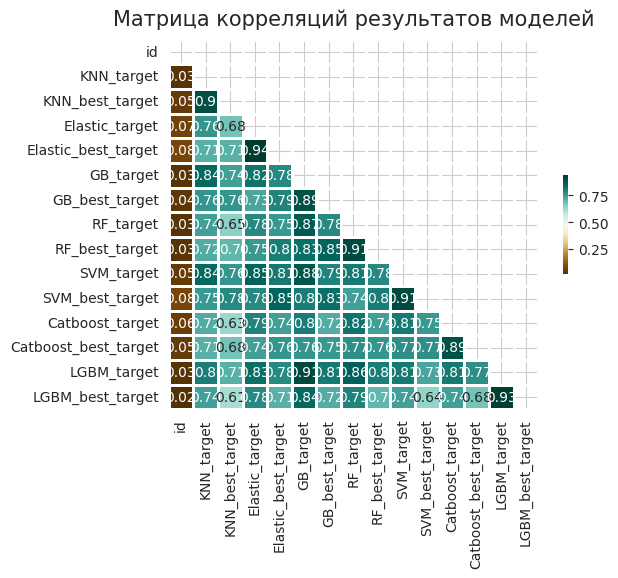

In [ ]:
sns.set_style("whitegrid")

mask = np.triu(np.ones_like(df_sub.corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(df_sub.corr(numeric_only=True).round(2),
                      annot=True,
                      square=True,
                      cmap="BrBG",
                      cbar_kws={"fraction": 0.01},
                      linewidth=1,
                      mask=mask)

heatmap.set_title("Матрица корреляций результатов моделей", fontdict={"fontsize": 15}, pad=10);

GB_target даёт близкие результаты с LGBM

## Разброс результатов

Попробуем посмотреть как наши модели предскажут известные нам данные. Выделим из train датасета  и предскажем её

In [ ]:
# разбиение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:
df_val = pd.DataFrame()
df_val['target_val'] = y_val.values
scores = {}

for el in bst_mdls:
   y_pred = bst_mdls[el].predict(X_val)
   df_val[el] = y_pred
   scores[el] = r2_score(y_true=y_val, y_pred=y_pred)

<Axes: >

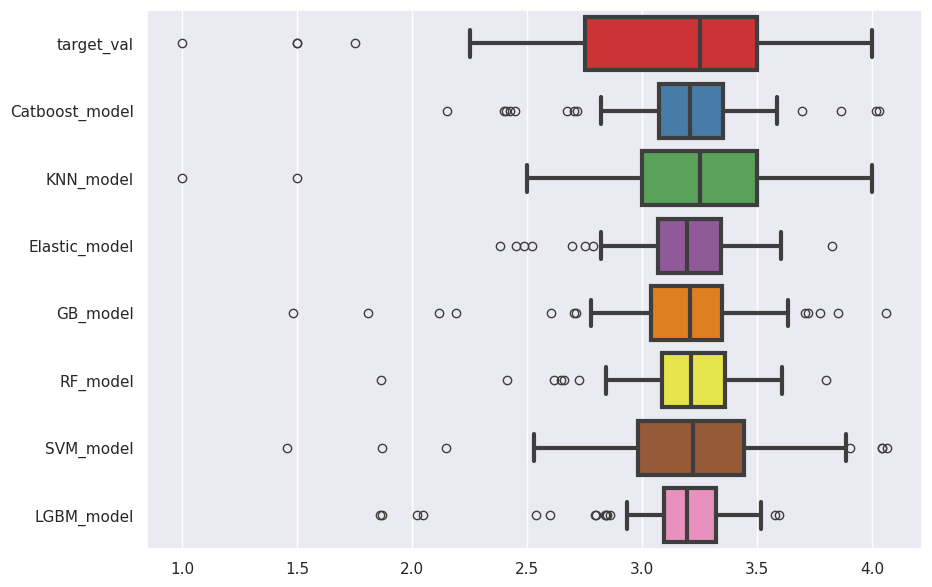

In [ ]:
sns.set(rc={"figure.figsize":(10, 7)})
sns.boxplot(data=df_val,whis=1,linewidth=3,orient="h",palette="Set1")

Неожиданно, но мне больше всего нравится SVM и KNN

# Blend

In [ ]:
df_sub_blending = df_sub.copy()

Для блендинга я взял результаты одиночных моделей. (раздел ниже). Выбрал 3 лучших. Их результаты занёс, нормализовал - получил веса. Результат не сильно, но всё же, преодолел планку в 0.2.

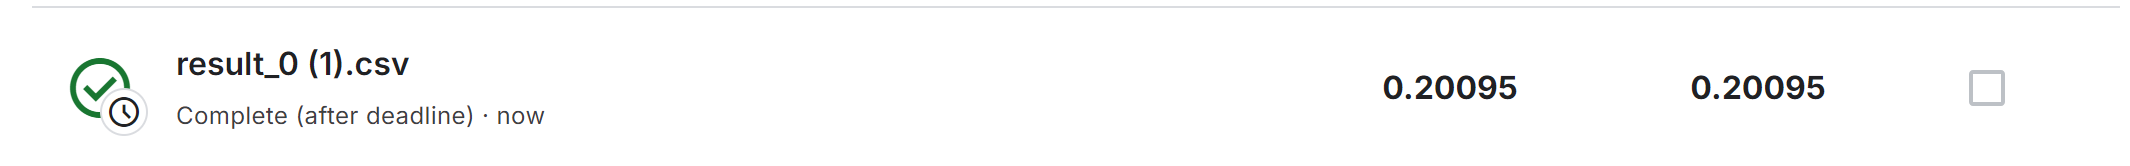

In [ ]:
Cat = 0.18543
Svm = 0.16354
Rf =  0.15620

Sum = Cat + Svm + Rf

weight_cat = Cat / Sum
weight_svm = Svm / Sum
weight_rf = Rf / Sum

weight_cat, weight_svm, weight_rf

(0.36706455252687215, 0.3237326048656888, 0.3092028426074391)

In [ ]:
# вариант выставления весов вручную
df_sub_blending['predictions'] = df_sub_blending['SVM_target'] * weight_svm + df_sub_blending['Catboost_target'] * weight_cat + df_sub_blending['RF_target'] * weight_rf
df_sub_blending.head()

,id,KNN_target,KNN_best_target,Elastic_target,Elastic_best_target,GB_target,GB_best_target,RF_target,RF_best_target,SVM_target,SVM_best_target,Catboost_target,Catboost_best_target,LGBM_target,LGBM_best_target,LGBM_target_cat,LGBM_best_target_cat,predictions
0,0,3.424027,3.401995,3.253106,3.229738,3.278857,3.249602,3.370875,3.412835,3.336480,3.277373,3.193763,3.213169,3.253004,3.293684,3.254565,3.258262,3.294729
1,1,3.036223,3.078853,2.960507,2.949508,2.968449,2.934727,3.042491,3.040006,3.110272,3.158821,3.002408,2.906929,2.873990,2.813293,2.883789,2.961340,3.049721
2,2,3.210654,3.208970,3.038371,3.060614,3.157075,3.203955,3.115140,3.121022,3.251566,3.237251,3.086893,3.075156,3.116815,3.176583,3.121572,3.113365,3.148937
3,3,3.536344,3.671341,3.412068,3.494340,3.747141,3.814789,3.574261,3.715428,3.946626,4.026637,3.309705,3.326895,3.433481,3.366330,3.511466,3.515359,3.597699
4,4,3.040406,3.129187,2.867476,2.921305,2.886826,2.889443,2.971720,2.958322,2.951289,2.986344,2.933190,3.109589,2.919001,2.822345,2.860159,2.953502,2.950963


In [ ]:
df_sub_blending_res = df_sub_blending[['id', 'predictions']]
df_sub_blending_res.rename(columns={'predictions': 'Rating'}).to_csv('result_0.csv', index=False)

# Single

In [ ]:
df_sub.head()

,id,KNN_target,KNN_best_target,Elastic_target,Elastic_best_target,GB_target,GB_best_target,RF_target,RF_best_target,SVM_target,SVM_best_target,Catboost_target,Catboost_best_target,LGBM_target,LGBM_best_target
0,0,3.424027,3.401995,3.253106,3.229738,3.278857,3.249602,3.370875,3.412835,3.336480,3.277373,3.193763,3.213169,3.253004,3.293684
1,1,3.036223,3.078853,2.960507,2.949508,2.968449,2.934727,3.042491,3.040006,3.110272,3.158821,3.002408,2.906929,2.873990,2.813293
2,2,3.210654,3.208970,3.038371,3.060614,3.157075,3.203955,3.115140,3.121022,3.251566,3.237251,3.086893,3.075156,3.116815,3.176583
3,3,3.536344,3.671341,3.412068,3.494340,3.747141,3.814789,3.574261,3.715428,3.946626,4.026637,3.309705,3.326895,3.433481,3.366330
4,4,3.040406,3.129187,2.867476,2.921305,2.886826,2.889443,2.971720,2.958322,2.951289,2.986344,2.933190,3.109589,2.919001,2.822345


In [ ]:
for i in df_sub.columns:
    if i != 'id':
        df_single = df_sub.copy()
        df_single = df_single[['id', i]]
        df_single.rename(columns={i: 'Rating'}).to_csv(f'{i}_simple.csv', index=False)

In [ ]:
# df_single = df_sub.copy()
# df_single = df_single[['id', 'Catboost_target']]

In [ ]:
# df_single.rename(columns={'Catboost_target': 'Rating'}).to_csv('C__simple.csv', index=False)

In [ ]:
import joblib


# Сохранение моделей
for model_name, model in bst_mdls.items():
    joblib.dump(model, f'{model_name}.pkl')

print("Модели сохранены.")

Модели сохранены.


In [ ]:
df_sub.to_csv('df_sub.csv', index=False)

In [ ]:
# df_single

# Stack

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# список базовых моделей
estimators = [
    ("RF", bst_mdls['RF_model']),
    ("Catboost", bst_mdls['Catboost_model']),
    # ("Elastik", bst_mdls['Elastic_model']),
    ("SVM", bst_mdls['SVM_model'])
    ]

meta_model = StackingRegressor(estimators=estimators,
                               final_estimator=LinearRegression(),
                               n_jobs=-1,
                               verbose=False)

stacking_regressor = meta_model
stacking_regressor.fit(X, y)

StackingRegressor(estimators=[('RF',
                               Pipeline(steps=[('feature_preprocessor',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='median')),
                                                                                                 ('scaler',
                                                                                                  StandardScaler())]),
                                                                                 ['Review',
                                                                                  'Cocoa_Percent']),
                                                                                ('cat',
                                                                                 Pipeline(steps=[('encoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['Specific_Bean_Origin',
                                                                                  'Company_Locatio...
                                                                                ('cat',
                                                                                 Pipeline(steps=[('encoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['Specific_Bean_Origin',
                                                                                  'Company_Location',
                                                                                  'Bean_Type',
                                                                                  'Broad_Bean_Origin',
                                                                                  'CompanyName',
                                                                                  'CompanySub',
                                                                                  'IsBlend',
                                                                                  'Bean_TypeSub',
                                                                                  'Cocoa_Percent_Category',
                                                                                  'Is_Domestic'])])),
                                               ('model',
                                                NuSVR(C=3.15, max_iter=720,
                                                      nu=0.55))]))],
                  final_estimator=LinearRegression(), n_jobs=-1, verbose=False)

In [ ]:
preds = stacking_regressor.predict(X_sub)
df_sub_stacking = df_sub.copy()
df_sub_stacking = df_sub_stacking[['id']]
df_sub_stacking['Rating'] = preds
df_sub_stacking.to_csv('result_1.csv', index=False)

# Ensemble

In [ ]:
!git clone https://github.com/MLWave/Kaggle-Ensemble-Guide

Cloning into 'Kaggle-Ensemble-Guide'...
remote: Enumerating objects: 116, done.
remote: Total 116 (delta 0), reused 0 (delta 0), pack-reused 116 (from 1)
Receiving objects: 100% (116/116), 23.29 KiB | 433.00 KiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
!python /content/Kaggle-Ensemble-Guide/src/kaggle_avg.py "/content/result_*.csv" "/content/all_blended.csv"

parsing: /content/result_0.csv
parsing: /content/result_1.csv
wrote to /content/all_blended.csv


Смесь блендинга и стекинга дал лучший результат.

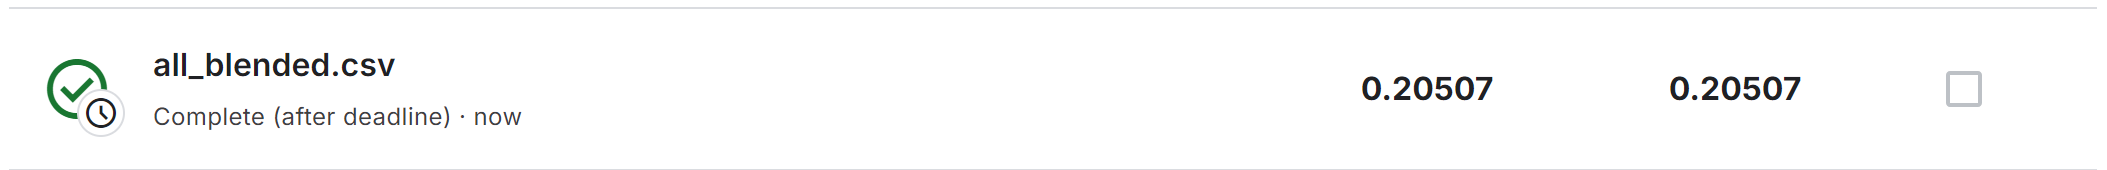

# Выводы

- В целом, вероятно не нужно было так обрабатывать признаки. Схожие результаты получал и без влезания в категориальные признаки.
- Впрочем, видимо остальные участники что-то делали гениальное с признаками, результаты очень сильные. И мне реально сложно придумать что было сделано.
- Не обрабатывал категориальные признаки из тестового датасета, хотя, например, там также были сокращения в странах. Была ещё идея попробовать страны закодировать, как текстовые признаки, но не использовал
- Для всех моделей была проведена кросс-валидация и на каждом фолде получались результы  для тестового датасета. Такая oob. Потом результаты усреднялись. Только такое получение результатов давало хоть что-то приемлимое. Также сохранял модели с лучшими результатом на каком-нибудь отдельном фолде, тем самым получая "лучшую" модель.
- Получал и результаты для модели, которая получила лучше результаты на каком-то фолде. Это ошибочная идея.
- Разбивал на 3 фолда, возможно следовало разбивать на большее количество.
- Блендинг по моделям дал результат. (3 модели выбрал по результатам и оценкам с каггла). Но лучше всего показал себя блендинг по блендингу и стекингу.
- Лучшей моделью оказался катбуст с внутренней обработкой категориальных признаков.
- Полиномиальные признаки не использовал, предположил, что вряд ли такие числовые признаки могут быть связаны.
- Вероятно модели сильно переобучаются и возможно лучше было разбивать обучение на большее количество фолдов для более качественного подбора параметров